<h1><center>DSA 4212: Year 2021</center></h1>

<h2><center> Group Member 1: Leong Jun Wen </center></h2>
<h2><center> Group Member 2: Douglas Wei Jing Allwood </center></h2>
<h2><center> Group Member 3: Lee Jun Xian Daryl </center></h2>
<h2><center> Group Member 4: Ong Wen Pin </center></h2>




# Derivative-free Optimization Techniques

#### Contents of this report:
* Algorithm implementations and the effects of their parameters
* Test cases to smoke test the algorithms
* Efficiency analysis: Rate of convergence
* Convergence analysis: Frequency of convergence


All code included in this report was written by Group 17 members ONLY.  

## 1. Particle Swarm Optimization

The Particle Swarm Optimization (PSO) algorithm uses a set of solutions (referred to as the particle swarm), that are initialized across the search space to find an approximate solution to the global minimum.  

The algorithm works by iteratively moving each particle of the swarm in a direction (referred to as *velocity*) that is the weighted sum of their previous best position, the global best position, and the direction of travel from their previous step.
The weights of these vectors are randomly chosen to ensure that the search is done stochastically. This is as random behaviour allows for better exploration of the search space as it may allow particles the escape a local minimum by travelling in a less optimal direction for some steps.
Furthermore, the velocity is multiplied by an inertia coefficient that shrinks towards zero, ensuring that particles eventually converge to some final position.


In [ ]:
def pso_optim(fn, bounds, n_particles = 50, epochs = 5e3, termination_threshold = 1e-8, inertia = 1, decay=0.999, return_history=False):
    """
    Optimises the given function using the Particle Swarm Optimisation (PSO) algorithm 
    to find a solution that obtains an approximate global minimum.
    
    Parameters
    ----------
    fn : function
        The objective function to be optimised.
        
    bounds : np.array
        A (d x 2) array indicating the d-dimensional lower and upper bounds of the solution space, respectively.
        
    n_particles : int
        The number of particles to use in the PSO
    
    epochs : int
        The number of iterations to run the optimisation algorithm for.
    
    termination_threshold : float
        The minimum standard deviation (or variation) of the previous 10 best objective values for which the 
        algorithm should continue to run.
        When the objective values produce a standard deviation smaller than this threshold the algorithm is 
        assumed to have converged and the optimal solution is returned.
    
    inertia : float
        The constant multiplied to each velocity vector before a movement is made.
    
    decay : float
        The constant multiplied to the inertia after each iteration to cause PSO to take smaller steps.
    
    return_history : boolean
        Whether to return a dictionary object containing information about the algorithms runtime execution.
    
    Returns
    -------
    g : np.array
        A (d x 1) array representing the optimal solution found by the PSO algorithm.
    """
    
    import numpy as np
    
    # The number of objective values to use to compute s.d. that will be compared to termination_threshold
    NUM_OBJECTIVE_VALUES_COMPUTE_STD = 10
        
    history = {
        'objective_values': [],
    }
    
    ##### 1. Initialize location of particles
    lower_bound = bounds[:, 0]
    upper_bound = bounds[:, 1]
    dim         = bounds.shape[0]
    particles = np.random.uniform(low = lower_bound, high = upper_bound, size = (n_particles, dim))
    
    # Used to enforce hard boundaries
    lower_bound_matrix = np.tile(lower_bound, (n_particles, 1))
    upper_bound_matrix = np.tile(upper_bound, (n_particles, 1))
    
    ##### 2. Initialize velocities of particles
    velocities = np.zeros((n_particles, dim))
    
    ##### 3. Track global and personal best
    p_best = particles
    p_best_fn = np.apply_along_axis(fn, 1, p_best)
    g_best = p_best[np.argmin(p_best_fn), :]
    
    ##### 4. Conduct search for n_iter number of iterations
    for i in range(int(epochs)):
        # Take a (scaled) step
        particles = particles + inertia * velocities
        
        # Enforce bounds with a hard boundary
        particles[particles < lower_bound_matrix] = lower_bound_matrix[particles < lower_bound_matrix]
        particles[particles > upper_bound_matrix] = upper_bound_matrix[particles > upper_bound_matrix]
        
        # Update p
        new_p_fn = np.apply_along_axis(fn, 1, particles)
        p_best[new_p_fn < p_best_fn] = particles[new_p_fn < p_best_fn]
        
        # Update g
        p_best_fn = np.apply_along_axis(fn, 1, p_best)
        g_best = p_best[np.argmin(p_best_fn), :]
        
        # Update velocities
        r_v = np.random.uniform(low = 0, high = 1, size = n_particles)
        r_p = np.random.uniform(low = 0, high = 1, size = n_particles)
        r_g = np.random.uniform(low = 0, high = 1, size = n_particles)
        velocities = (r_v * velocities.T).T + (r_p * (p_best - particles).T).T + (r_g * (g_best - particles).T).T
        
        # Update inertia
        inertia = inertia * decay
        
        # Update history
        history['objective_values'].append(fn(g_best))
        
        # Check for early termination
        past_objective_values = history['objective_values'][-NUM_OBJECTIVE_VALUES_COMPUTE_STD:]
        if (len(past_objective_values) == NUM_OBJECTIVE_VALUES_COMPUTE_STD) and np.std(past_objective_values) <= termination_threshold:
            break
        
    ##### 5. Return the global min that was found
    return (g_best, history) if return_history else g_best

### Theory of PSO parameters
For Particle Swarm Optimization, our tunable parameters are namely: number of particles to be used in the PSO, number of iterations that the optimization algorithm runs for (epochs), inertia which is the constant multiplied to each velocity vector before a movement is made and decay which is the constant multiplied to the inertia after each iteration for particles to take smaller steps.

Since PSO uses a swarm of particles to search the space, the number of particles chosen can affect both efficiency - rate of convergence - and convergence properties - whether the algorithm finds the global minimum. While choosing more particles offers better efficiency and convergence, this can slow down computational time of the algorithm.

The inertia parameter controls the size of the steps that particles take in each iteration and must not be too large as it can cause 'exploding' steps to occur, whereby each step is a factor larger than the previous, leading to steps that are eventaully too large and always step past the global minimum. When chosen correctly, inertia offers a balance between the exploration - visiting different regions in the search space to locate a good optimum - and exploitation - concentrating the search around a promising candidate solution to precisely locate an optimum - characteristics of the PSO algorithm. If inertia weight is large, it might lead to a more extensive exploration whereas a small value of inertia weight promotes local exploitation. Hence, if velocity is too low, the algorithm may be too slow whereas if it’s too high, the algorithm might become too unstable. 

Lastly, decay helps shift the PSO algorithm from a global search to more of a local search as the iterations progress by shrinking the size of steps particles move. Hence, it should be set to a value which promotes initial exploration to identify many potential solutions before decreasing the inertia coefficient causing particles to do a local search in the later stage of the algorithm.

Overall, the balance between global and local search is vital for a successful PSO.

## 2. Simulated Annealing

Simulated annealing (SA) works by performing a sort of random walk in the search space that is stochastically controlled by the function to be optimised and the 'temperature' of the algorithm.  

Initially, when the temperature is high, random movements of the current position are accepted with high probability, even if they lead to worse objective values, however as time goes by and the temperature drops, the algorithm becomes more selective in taking steps that lead to worse objective values.  

In [ ]:
def simulated_annealing_optim(fn, bounds, epochs = 1e4, termination_threshold = 1e-8, step_size = 0.01, temperature = 1000, verbose = False, return_history = False):
    """
    Optimises the given function using the Simulated Annealing (SA) algorithm 
    to find a solution that obtains an approximate global minimum.
    
    Parameters
    ----------
    fn : function
        The objective function to be optimised.
        
    bounds : np.array
        A (d x 2) array indicating the d-dimensional lower and upper bounds of the solution space,  respectively.
        
    epochs : int
        The number of iterations to run the optimisation algorithm for.
        
    termination_threshold : float
        The minimum standard deviation (or variation) of the previous 10 best objective values for which the 
        algorithm should continue to run.
        When the objective values produce a standard deviation smaller than this threshold the algorithm is 
        assumed to have converged and the optimal solution is returned.
    
    step_size : float
        The standard deviation of the normal distribution from which the random walk's step will be sampled from.
        A larger step size results in greater chance of exploration at the risk of failure to converge.
    
    temperature : float
        The starting temperature of the SA algorithm.
        A higher temperature results in greater chance of exploration at the risk of failure to converge.
    
    verbose : boolean
        A boolean indicating whether to print the SA algorithm's progress every 1000 iterations.
    
    return_history : boolean
        Whether to return a dictionary object containing information about the algorithms runtime execution.
    
    Returns
    -------
    s_best : np.array
        A (d x 1) array representing the optimal solution found by the SA algorithm.
    """
    import numpy as np
    
    # The number of objective values to use to compute s.d. that will be compared to termination_threshold
    NUM_OBJECTIVE_VALUES_COMPUTE_STD = 10
    
    history = {
        'objective_values': [],
        'unique_objective_values': [],
    }
    
    lower_bound = bounds[:, 0]
    upper_bound = bounds[:, 1]
    dim = bounds.shape[0]
    mid = ((lower_bound + upper_bound) / 2) + np.random.normal(size = dim) * step_size
    
    s = mid
    fn_s = fn(s)
    
    s_best = s
    fn_best = fn_s
    
    for i in range(int(epochs)):
        s_candidate = s + np.random.normal(size = dim) * step_size
        
        # Enforce bounds with a hard boundary
        s_candidate[s_candidate > upper_bound] = upper_bound[s_candidate > upper_bound]
        s_candidate[s_candidate < lower_bound] = lower_bound[s_candidate < lower_bound]
        
        fn_s_candidate = fn(s_candidate)
        
        if fn_s_candidate < fn_best:
            s_best, fn_best = s_candidate, fn_s_candidate
            
            # Update unique history
            history['unique_objective_values'].append(fn_best)
            
            if (verbose):
                print(f"Iteration: {i}\tSolution: {s_best}\tObjective Value: {fn_best}")

        delta = fn_s_candidate - fn_s
        t = temperature / float(i + 1)
        metropolis = -delta / t
        if delta < 0 or np.log(np.random.uniform()) < metropolis:
            s, fn_s = s_candidate, fn_s_candidate
        
        # Update history
        history['objective_values'].append(fn_best)
        
        # Check for early termination
        past_objective_values = history['unique_objective_values'][-NUM_OBJECTIVE_VALUES_COMPUTE_STD:]
        if (len(past_objective_values) == NUM_OBJECTIVE_VALUES_COMPUTE_STD) and np.std(past_objective_values) <= termination_threshold:
            break
        
    return (s_best, history) if return_history else s_best

### Theory of SA parameters
For Simulated Annealing, the tunable parameters are the: number of epochs (iterations), step size, and starting temperature.

The step size is the standard deviation of the normal distribution that the random walk’s step is sampled from. There is a trade-off between step size and convergence such that a large step size would allow for greater exploration in search of a global optimum at the cost of taking longer to thoroughly search the larger space. On the other hand, a small step size might see the algorithm converge to a local optimum value instead as the algorithm might cool before it travels too far.

The temperature parameter of the algorithm is a parameter value that gradually decays at a rate proportional to $\frac{1}{k}$ where k is the iteration number. Temperature, in this case, relates to acceptance criterion, the Metropolis criterion that is utilized in our implementation of the SA algorithm. Starting with a higher temperature means that at each iteration the next candidate point will have a higher probability of being accepted. It can be said that a higher starting temperature allows for greater exploration as it increases the probability of accepting movements, even if they are bad in the short-term, allowing the algorithm to escape from a local optimum. However, setting the starting temperature to be too high might make the initial stages of the algorithm meaningless as the algorithm would basically accept any proposed candidate point as the new current point in every iteration, which has the same effect as randomly choosing several starting points and evaluating which is the best before proceeding with any algorithmic search.  

It should be noted, however, that there is no fixed method to finding the best temperature value for optimizing each objective function.

Lastly, the number of epochs the algorithm is run for must be balanced according to the starting temperature provided, as once temperature has shrunk to a small value, the search point is unlikely to move and additional iterations are likely to be pointless, increasing computational time without offering any benefits.

## 3. Nelder-Mead

The Nelder-Mead (NM) algorithm works by using a simplex containing (d+1) vertices, where d is the dimension of the search space, to find an approximate global minimum.  

The algorithm iteratively evaluates the objective value at each vertex and reflects (or contracts if reflection leads to a bad outcome) the worst performing vertex towards the geometric center of the remaining d vertices.  

Specifically, at every iteration the NM algorithm performs one of four steps on the worst-performing vector ($w$), in relation to the centroid ($c$):
* Reflect $w$ about $c$ to produce $r$
* Extend $r$ further if $r$ is the better than all other d vertices
* Contract $w$ towards $c$ if $r$ is better than before but worse than all other d vertices
* Shrink all vertices towards the best performing vertex if $r$ is worse than $w$

Notably, this search behaviour means that the Nelder-Mead method is effectively a hill-climbing (or in the minimisation case, hill-descending) algorithm and that it cannot escape local minima's and hence does not work well for multi-modal functions, functions with both local and global minimums.

In [ ]:
def nelder_mead_optim(fn, bounds, epochs = 5e5, termination_threshold = 1e-8, alpha = 1, gamma=2, rho=0.5, sigma=0.5, return_history=False):
    """
    Optimises the given function using the Nelder-Mead (NM) algorithm 
    to find a solution that obtains an approximate global minimum.
    
    This optimisation algorithm respects the boundaries provided and defines the objective value of the given 
    function to be MAX_VALUE when called on a value outside of its domain.
    
    Parameters
    ----------
    fn : function
        The objective function to be optimised.
        
    bounds : np.array
        A (d x 2) array indicating the d-dimensional lower and upper bounds of the solution space,  respectively.
        
    epochs : int
        The number of iterations to run the optimisation algorithm for.
    
    termination_threshold : float
        The minimum standard deviation (or variation) of the objective values of each vertex of the 
        simplex for which the algorithm should continue to run.
        When the objective values produce a standard deviation smaller than this threshold the algorithm is 
        assumed to have converged and the optimal solution is returned.
    
    alpha : float
        The scaling parameter for the reflection step.
        This step is taken if the reflection steps objective value is between the 1-st and n-th best or 
        better than the expansion steps objective value, if one is calculated.
    
    gamma : flaot
        The scaling parameter for the expansion step.
        The reflected vector is scaled by this value.
        This step is taken if the reflection steps objective value is better than the previous best but 
        worse than the expansion steps objective value.
        
    rho : float
        The scaling parameter for the contraction step.
        This step is taken if the reflection steps objective value is between the n-th and (n+1)-th best.
    
    sigma : float
        The scaling parameter for the reduction step.
        This step is taken if the reflection steps objective value is greater than the (n+1)-th best.
    
    return_history : boolean
        Whether to return a dictionary object containing information about the algorithms runtime execution.
    
    Returns
    -------
    s_best : np.array
        A (d x 1) array representing the optimal solution found by the NM algorithm.
    """
    import numpy as np
    
    history = {
        'objective_values': [],
    }
    
    MAX_VALUE = np.finfo(np.dtype('float64')).max
    # fn: x -> fn(x) if x is in the functions domain and MAX_VALUE otherwise
    
    dim = bounds.shape[0]
    lower_bound = bounds[:, 0]
    upper_bound = bounds[:, 1]
    
    # Function to check if a point is within the bounds
    isWithinBounds = lambda x: ((lower_bound <= x) & (x <= upper_bound)).all()
    
    points = np.random.uniform(low = lower_bound, high = upper_bound, size=(dim + 1, dim))
    evals  = np.apply_along_axis(fn, 1, points)
    
    for i in range(int(epochs)):
        # Sort the points
        sorted_indexes = np.argsort(evals)
        points = points[sorted_indexes, :]
        evals  = evals[sorted_indexes]
        
        # Compute the centroid excluding the (n+1)-th point
        centroid = np.mean(points[:-1, :], axis=0)
        
        # Find alpha-scaled reflection
        alpha_reflected = centroid + alpha * (centroid - points[-1, :])
        alpha_eval = fn(alpha_reflected) if isWithinBounds(alpha_reflected) else MAX_VALUE
        
        # Reflection
        if evals[0] <= alpha_eval < evals[-2]:
            points[-1, :] = alpha_reflected
            evals[-1] = alpha_eval
        
        # Expansion
        elif alpha_eval < evals[0]:
            gamma_reflected = centroid + gamma * (alpha_reflected - centroid)
            gamma_eval = fn(gamma_reflected) if isWithinBounds(gamma_reflected) else MAX_VALUE
            
            if gamma_eval < alpha_eval:
                points[-1, :] = gamma_reflected
                evals[-1] = gamma_eval
            else:
                points[-1, :] = alpha_reflected
                evals[-1] = alpha_eval
        
        # Inner and Outer contraction
        elif evals[-2] <= alpha_eval < evals[-1]:
            # Outer contraction
            rho_outer_contracted = centroid + rho * (centroid - points[-1, :])
            rho_outer_eval = fn(rho_outer_contracted) if isWithinBounds(rho_outer_contracted) else MAX_VALUE
            
            # Inner contraction
            rho_inner_contracted = centroid + rho * (points[-1, :] - centroid)
            rho_inner_eval = fn(rho_inner_contracted) if isWithinBounds(rho_inner_contracted) else MAX_VALUE
            
            if rho_outer_eval < rho_inner_eval:
                points[-1, :] = rho_outer_contracted
                evals[-1] = rho_outer_eval
            else:
                points[-1, :] = rho_inner_contracted
                evals[-1] = rho_inner_eval
        
        # Reduction
        else:
            # evals[-1] < alpha_eval
            points[1:, :] = points[0, :] + sigma * (points[1:, :] - points[0, :])
            evals[1:] = np.apply_along_axis(fn, 1, points[1:, :])
        
        # Update history
        history['objective_values'].append(np.min(evals))
        
        # Check for early termination
        if np.std(evals) < termination_threshold:
            break
        
    
    # Return the optimal solution, i.e. the solution that produces the smallest objective value
    optimal_solution = points[np.argmin(evals), :]
    return (optimal_solution, history) if return_history else optimal_solution

### Theory Of NM parameters
For the Nelder-Mead optimization algorithm, the tunable parameters are the number of epochs, the termination threshold, and the four scaling parameters of alpha, gamma, rho and sigma that are the coefficients for reflection, expansion, contraction and reduction, respectively.

Based on the original academic writings by John Nelder and Roger Mead, who conducted numerous trials experimenting on various parameter combinations for the scaling parameters of alpha, gamma, rho and sigma, they found that out of all of their proposed combinations of parameters, the values of alpha = 1, gamma = 2, rho = 0.5 and sigma = 0.5 tended to work generally well. Later parameter sensitivity studies revealed parameter values that might be even better for the Nelder-Mead algorithm, but for our implementation, we decided to stick to the generally accepted parameter values.

The termination threshold is used to determine whether the algorithm has converged. It is used as the minimum standard deviation of the function values of each vertex required before the algorithm terminated.

Choosing the number of epochs depends on how large the search space is, too few epochs will prevent the vertices from converging before the algorithm terminates, especially if they started far apart. On the other hand, too many epochs are pointless once the vertices converge as they will not move significantly from that point onwards. Hence, this emphasises the benefit of the termination threshold terminating the algorithm once the vertices converge, allowing an arbitatrily large number of epochs to chosen in most cases. Some cases where it is not wise to choose a large number of epochs are for discontinuous or step functions whereby the vertices might never converge.


## 4. Test functions

For this report, Group 17 will test our implementations of the three optimization functions listed above on the following 6 test functions.  

Source of test case functions: [Wikipedia: Test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization)

### Sphere function
$$
f(\mathbf{x}) = \sum^{n}_{i=1}x_i^2
\\
\text{Bounds: } -\infty \leq x, y \leq \infty
\\
\text{Minimized at: } f(0, ..., 0) = 0
$$

### Eggholder function
$$
f(x, y) = -(y + 47) \sin \sqrt{ \left\lvert \frac{x} {2} + (y + 47) \right\rvert } - x \sin \sqrt{ \left\lvert x - (y + 47) \right\rvert }
\\
\text{Bounds: } -512 \leq x, y \leq 512
\\
\text{Minimized at: } f(512, 404.2319) = -959.6407
$$

### Booth function
$$
f(x, y) = (x + 2y -7)^2 + (2x + y - 5)^2
\\
\text{Bounds: } -10 \leq x, y \leq 10
\\
\text{Minimized at: } f(1, 3) = 0
$$

### Matyas function
$$
f(x, y) = 0.26(x^2 + y^2) - 0.48xy
\\
\text{Bounds: } -10 \leq x, y \leq 10
\\
\text{Minimized at: } f(0, 0) = 0
$$

### Levi function N. 13
$$
f(x, y) = \sin^2 3 \pi x + (x - 1)^2 (1 + \sin^2 3 \pi y) + (y - 1)^2 (1 + \sin^2 2 \pi y)
\\
\text{Bounds: } -10 \leq x, y \leq 10
\\
\text{Minimized at: } f(1, 1) = 0
$$

### Cross-in tray function
$$
f(x, y) = -0.0001 \left[ \left\lvert \sin{x} \sin{y} \exp \left( \left\lvert 100 - \frac{\sqrt{x^2 + y^2}} {\pi} \right\rvert \right) \right\rvert + 1 \right]^{0.1}
\\
\text{Bounds: } -10 \leq x, y \leq 10
\\
\text{Minimized at: } f(\pm 1.39491, \pm 1.34941) = -2.06261
$$

In [ ]:
import numpy as np

def sphere_fn(x):
    return np.sum(x**2)


def egg_holder_fn(X):
    x = X[0]
    y = X[1]
    return -(y + 47) * np.sin(np.sqrt(np.abs((x/2) + y + 47))) - x * np.sin(np.sqrt(np.abs(x - y - 47)))


def booth_fn(X):
    x = X[0]
    y = X[1]
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2


def matyas_fn(X):
    x = X[0]
    y = X[1]
    return 0.26*(x**2 + y**2) - 0.48*x*y


def levi_fn(X):
    x = X[0]
    y = X[1]
    return np.sin(3 * np.pi * x)**2 + (x - 1)**2 * (1 + np.sin(3 * np.pi * y)**2) + (y-1)**2 * (1 + np.sin(2 * np.pi * y)**2)


def cross_in_tray_fn(X):
    x = X[0]
    y = X[1]
    return - 0.0001 * (np.abs( np.sin(x) * np.sin(y) * np.exp(np.abs(100 - (np.sqrt(x**2 + y**2) / np.pi))) ) + 1) ** 0.1


def test(optim_fn, fn, bounds = np.array([[-10, 10], [-10, 10]]), sep = "\t", width = 50, precision=4):
    _ = optim_fn(fn, bounds)
    opt_string = f"Optimisation method: {optim_fn.__name__}"
    obj_string = f"Objective function: {fn.__name__}"
    val_string = f"Optimal value: {round(fn(_), precision)}"
    sol_string = f"Optimal solution: {np.round(_, precision)}"
    print(f"{opt_string:{width}}{sep}{obj_string:{width}}{sep}{val_string:{width}}{sep}{sol_string:{width}}")

In [ ]:
import random
random.seed(10)

## 4.1 Test: PSO

In [ ]:
test(pso_optim, sphere_fn)
test(pso_optim, egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]))  # Fails to converge
test(pso_optim, booth_fn)
test(pso_optim, matyas_fn)
test(pso_optim, levi_fn)
test(pso_optim, cross_in_tray_fn)

Optimisation method: pso_optim                    	Objective function: sphere_fn                     	Optimal value: 0.0                                	Optimal solution: [-0.  0.]                       
Optimisation method: pso_optim                    	Objective function: egg_holder_fn                 	Optimal value: -557.3687                          	Optimal solution: [-506.2582    6.3131]           
Optimisation method: pso_optim                    	Objective function: booth_fn                      	Optimal value: 0.0                                	Optimal solution: [1. 3.]                         
Optimisation method: pso_optim                    	Objective function: matyas_fn                     	Optimal value: 0.0                                	Optimal solution: [-0. -0.]                       
Optimisation method: pso_optim                    	Objective function: levi_fn                       	Optimal value: 0.0                                	Optimal solution: [1. 1.]      

## 4.2 Test: Simulated Annealing

In [ ]:
test(simulated_annealing_optim, sphere_fn)
test(simulated_annealing_optim, egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]))  # Fails to converge
test(simulated_annealing_optim, booth_fn)
test(simulated_annealing_optim, matyas_fn)
test(simulated_annealing_optim, levi_fn) # Fails to converge sometimes
test(simulated_annealing_optim, cross_in_tray_fn)

Optimisation method: simulated_annealing_optim    	Objective function: sphere_fn                     	Optimal value: 0.0                                	Optimal solution: [ 0.0021 -0.    ]               
Optimisation method: simulated_annealing_optim    	Objective function: egg_holder_fn                 	Optimal value: -51.728                            	Optimal solution: [3.7045 6.5634]                 
Optimisation method: simulated_annealing_optim    	Objective function: booth_fn                      	Optimal value: 0.0                                	Optimal solution: [0.9987 2.9999]                 
Optimisation method: simulated_annealing_optim    	Objective function: matyas_fn                     	Optimal value: 0.0                                	Optimal solution: [-0.0052 -0.004 ]               
Optimisation method: simulated_annealing_optim    	Objective function: levi_fn                       	Optimal value: 1.4266                             	Optimal solution: [0.3407 0.012

## 4.3 Test: Nelder-Mead

In [ ]:
test(nelder_mead_optim, sphere_fn)
test(nelder_mead_optim, egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]))  # Fails to converge
test(nelder_mead_optim, booth_fn)
test(nelder_mead_optim, matyas_fn)
test(nelder_mead_optim, levi_fn) # Fails to converge sometimes
test(nelder_mead_optim, cross_in_tray_fn) # Fails to converge sometimes

Optimisation method: nelder_mead_optim            	Objective function: sphere_fn                     	Optimal value: 0.0                                	Optimal solution: [-0. -0.]                       
Optimisation method: nelder_mead_optim            	Objective function: egg_holder_fn                 	Optimal value: -718.1675                          	Optimal solution: [ 283.0763 -487.1257]           
Optimisation method: nelder_mead_optim            	Objective function: booth_fn                      	Optimal value: 0.0                                	Optimal solution: [1. 3.]                         
Optimisation method: nelder_mead_optim            	Objective function: matyas_fn                     	Optimal value: 0.0                                	Optimal solution: [-0. -0.]                       
Optimisation method: nelder_mead_optim            	Objective function: levi_fn                       	Optimal value: 0.1099                             	Optimal solution: [0.6704 1.   

## 5. Performance analysis: Efficiency

In this section, we analyse the rate of convergence of the 3 optimisation algorithms when tested on each of the 6 test functions.  
For example, we will compare how many iterations the 3 optimisation algorithms find the global minimum of the sphere function, and how the cost function decreases over each iteration.  

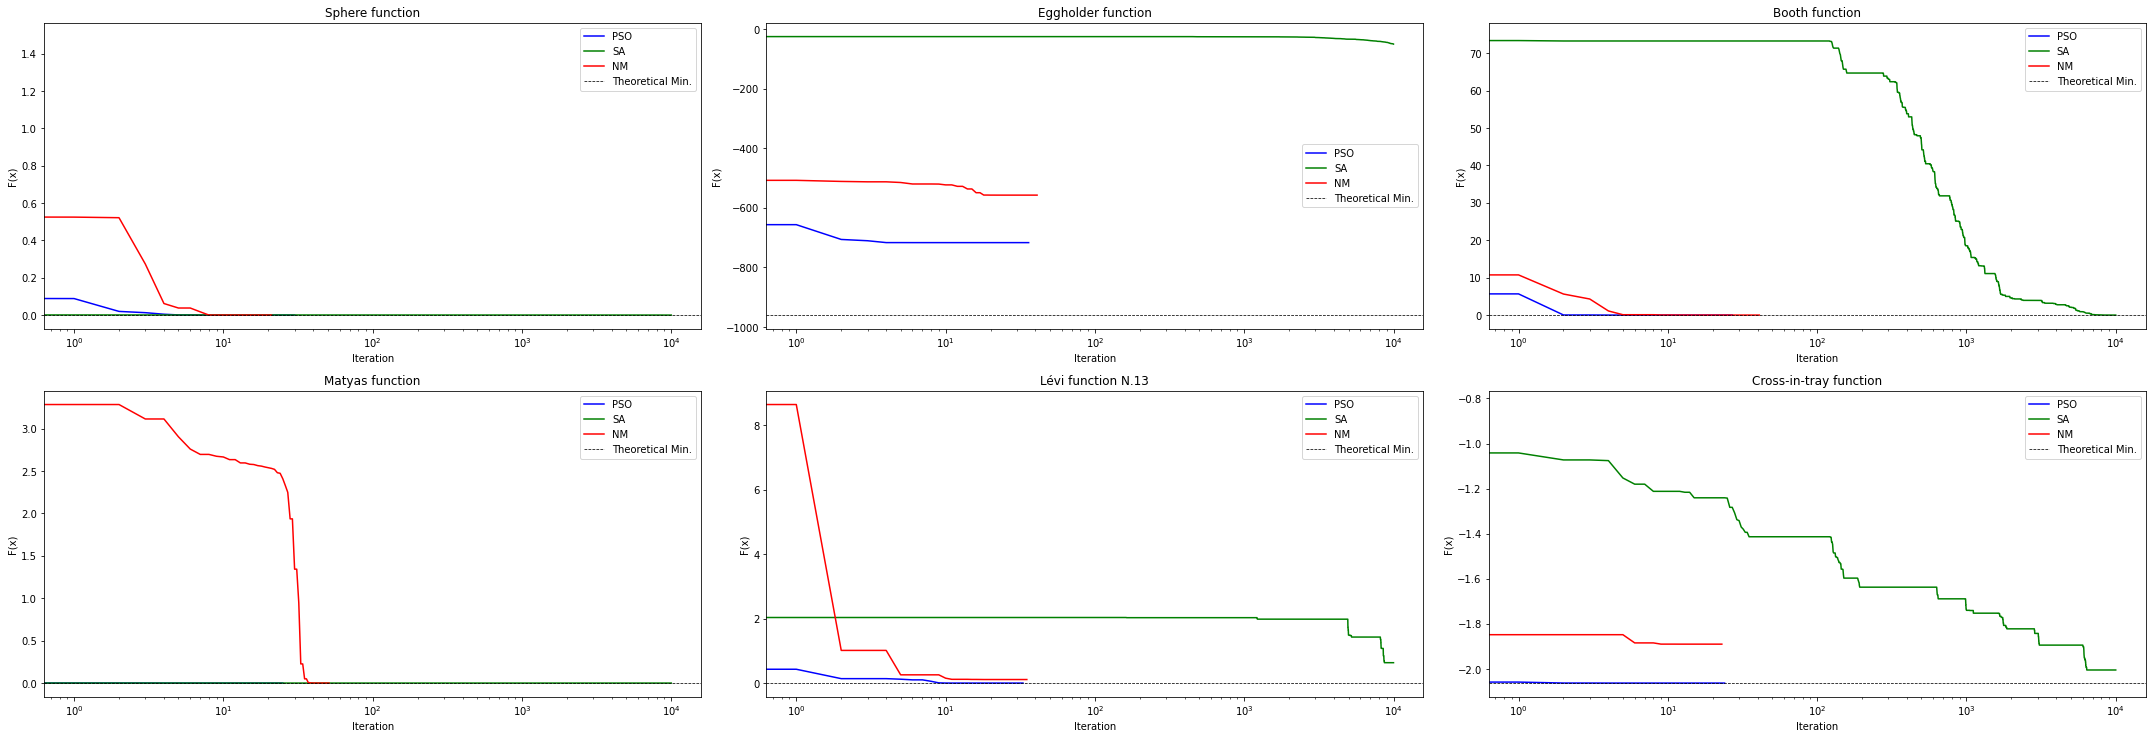

In [ ]:
random.seed(4212)
_, pso_sphere = pso_optim(sphere_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, pso_egg    = pso_optim(egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]), return_history = True) # Fails to converge
_, pso_booth  = pso_optim(booth_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, pso_matyas = pso_optim(matyas_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, pso_levi   = pso_optim(levi_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, pso_cross  = pso_optim(cross_in_tray_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)

_, sa_sphere  = simulated_annealing_optim(sphere_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, sa_egg     = simulated_annealing_optim(egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]), return_history = True) # Fails to converge
_, sa_booth   = simulated_annealing_optim(booth_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, sa_matyas  = simulated_annealing_optim(matyas_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, sa_levi    = simulated_annealing_optim(levi_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True) # Fails to converge sometimes
_, sa_cross   = simulated_annealing_optim(cross_in_tray_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)

_, nm_sphere  = nelder_mead_optim(sphere_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, nm_egg     = nelder_mead_optim(egg_holder_fn, bounds = np.array([[-512, 512], [-512, 512]]), return_history = True) # Fails to converge
_, nm_booth   = nelder_mead_optim(booth_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, nm_matyas  = nelder_mead_optim(matyas_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True)
_, nm_levi    = nelder_mead_optim(levi_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True) # Fails to converge sometimes
_, nm_cross   = nelder_mead_optim(cross_in_tray_fn, bounds = np.array([[-10, 10], [-10, 10]]), return_history = True) # Fails to converge sometimes

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

rcParams['figure.figsize'] = 30, 15

plt.subplot(3, 3, 1)
plt.plot(pso_sphere['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_sphere['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_sphere['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = 0., color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Sphere function')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(pso_egg['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_egg['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_egg['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = -959.6407, color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Eggholder function')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(pso_booth['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_booth['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_booth['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = 0., color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Booth function')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.subplot(3, 3, 4)
plt.plot(pso_matyas['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_matyas['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_matyas['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = 0., color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Matyas function')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(pso_levi['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_levi['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_levi['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = 0., color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Lévi function N.13')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(pso_cross['objective_values'], label = 'PSO', color = 'b')
plt.plot(sa_cross['objective_values'], label = 'SA', color = 'g')
plt.plot(nm_cross['objective_values'], label = 'NM', color = 'r')
plt.axhline(y = -2.06261, color='k', linestyle='dashed', linewidth=0.75, label = 'Theoretical Min.')
plt.title('Cross-in-tray function')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.legend()

plt.tight_layout()
plt.show();

Important note: The end of a given line indicates that the algorithm has terminated / converged.  
For example, in the sphere function as shown in the top-left plot, PSO (blue) terminates the earliest whereas SA (green) extends to $10^4$ iterations, terminating the last.

#### Initialization values
For the 3 optimization algorithms, the way we initialised their starting values is what causes the initial differences of $F(X)$ values seen on the y-axis.  
For example, 
* PSO is initialized with the swarm being uniformly distributed across the search space, hence giving it high probability of starting with a few particles with low objective value as they may randomly happen to be near the optimal solution.
* SA is initialized near the middle of its search space (with a slight random perturbation), hence for most objective functions with optimal solution at $(0, 0)$, it starts with extremely low objective value as it is initialised very close to this.
* NM is initialized with (d+1) vertices that are uniformly spread out across the search space, hence for most objective functions with optimal solution at $(0, 0)$, the NM vertices are not likely to be near the middle of the search space as they will form a simplex around it, and hence will have high objective value to begin with.


#### Analysis of 2 plots from above:

##### a) Sphere function
We see that PSO and NM converge relatively quickly to the global minimum when compared to SA.  

The slow convergence of SA could be because the Temperature parameter for SA was not tuned to be optimal for each of the given test functions.
Hence, it may have spent many iterations exploring the space while temperature was high, before converging.  
Additionally, for any given point in the sphere function that is not the optimal solution (0,0), there are many directions to move in which the cost function would reduce - even if the point does not move exactly towards (0,0) the cost function can reduce if it just gets closer to (0,0). Hence, the random choice of step-directions by SA could have contributed to a low consistency or precision in its objective values, causing the early termination threshold to never be met.

The quick convergence of NM as compared to SA could be due to the fact that the sphere function is convex and uni-modal, hence having the optimal topology for the NM algorithm which effectively performs hill-descent.  

The PSO algorithm converged the fastest, this could be due to the combined effect of these two factors:  
(1) Initialization of some particle near to the optimal solution  
(2) Robustness of PSO to its parameters, meaning that though the parameters were not tuned for finding the minimum of the sphere_fn, the PSO algorithm could still perform well

###### Topology of sphere function
![Topology-of-sphere-function](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Sphere_function_in_3D.pdf/page1-320px-Sphere_function_in_3D.pdf.jpg)

##### b) Eggholder function
* PSO to the global optimum after approximately 30 iterations
* NM converged to a local minimum after approximately 30 iterations
* SA barely reduced its objective value for the first 1000 iterations

Once again, the poor performance of SA could be due to the selection of its parameter values, however this time instead of temperature it is likely to be `step_size` that is the culprit.  
This is as our SA algorithm starts with `temperature=1000` by default, making the algorithm "hot" enough to explore the search space.  
However, given that the objective value did not decrease much, this suggests that the SA algorithm was taking too small steps while exploring, so though it was allowed to explore for many iterations, it did not successfully reach better areas of the eggholder function.  

The NM algorithm also failed to converge to the optimal solution, this could be due to the fact that there are multiple local-minimas in the eggholder function, that could trap the NM algorithm as, in the implementation we used, it has no way of escaping from a local minima as it simply performs hill-descent.  
Therefore, once NM had begun descending into the wrong valley, it would not have been able to escape, but only to converge quickly to the local minimum of that valley.  
A suggestion could be to randomly restart the NM algorithm after it converges, and do so several times, in the hopes that it might randomly converge to the global minimum.  

The PSO algorithm appears to have successfully converged to the global minimum. However, as we will see in the next section on convergence, it only does so for the eggholder function approximately 12% of the time.  

Overall, the eggholder function's topology is difficult for these meta-heuristic algorithms to optimise as it presents many valleys with local minimums that can trap these algorithms.  

###### Topology of eggholder function
![Topology-of-eggholder-function](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Eggholder_function.pdf/page1-320px-Eggholder_function.pdf.jpg)

##### Efficiency conclusion
Similar analysis as done in (a) and (b) can be applied to the other plots shown above.  
Overall, the plots show us that simulated annealing's parameters of `temperature` and `step_size` need to be chosen appropriately for the given objective function, or the SA algorithm might perform poorly.  
Conversely, NM and PSO seem to be robust to parameter selection but NM can easily be trapped in a valley containing a local minimum.  

Lastly, since these are stochastic algorithms, they are not always guaranteed to converge.  
The next section will study the proportion of time they converged for each of the 6 given test functions, to validate if the conclusions in this section on their efficiency hold true when repeated multiple times.  

Source of images: https://en.wikipedia.org/wiki/Test_functions_for_optimization

## 6. Performance analysis: Convergence

In this section we will analyse the frequency at which the 3 optimisation algorithms are able to converge to the global minimum of the 6 test functions listed above.  

For example, we will analyse the proportion of times the PSO algorithm converges to the global minimum of the sphere function, $\begin{pmatrix}0 \\ 0 \end{pmatrix}$.

In [ ]:
optim_functions = [pso_optim, simulated_annealing_optim, nelder_mead_optim]
test_functions = [sphere_fn, egg_holder_fn, booth_fn, matyas_fn, levi_fn, cross_in_tray_fn]

results = []

for optim_fn in optim_functions:
    for test_fn in test_functions:
        for i in range(100):
            print(f"Optim function: {optim_fn.__name__:20}\tTest function: {test_fn.__name__:25}") if i == 0 else None
            bounds = np.array([[-10, 10], [-10, 10]])
            
            if test_fn.__name__ == 'egg_holder_fn':
                bounds = np.array([[-512, 512], [-512, 512]])
            
            result = [optim_fn.__name__, test_fn.__name__, optim_fn(test_fn, bounds)]
            results.append(result)

Optim function: pso_optim           	Test function: sphere_fn                
Optim function: pso_optim           	Test function: egg_holder_fn            
Optim function: pso_optim           	Test function: booth_fn                 
Optim function: pso_optim           	Test function: matyas_fn                
Optim function: pso_optim           	Test function: levi_fn                  
Optim function: pso_optim           	Test function: cross_in_tray_fn         
Optim function: simulated_annealing_optim	Test function: sphere_fn                
Optim function: simulated_annealing_optim	Test function: egg_holder_fn            
Optim function: simulated_annealing_optim	Test function: booth_fn                 
Optim function: simulated_annealing_optim	Test function: matyas_fn                
Optim function: simulated_annealing_optim	Test function: levi_fn                  
Optim function: simulated_annealing_optim	Test function: cross_in_tray_fn         
Optim function: nelder_mead_optim 

In [ ]:
import pandas as pd

# The maximum allowed difference between the solution and the optimal solution
# for a solution to be considered as correct
CONVERGENCE_THRESHOLD = 0.1

solutions = {
    'sphere_fn': np.array([0, 0]),
    'egg_holder_fn': np.array([512, 404.2319]),
    'booth_fn': np.array([1, 3]),
    'matyas_fn': np.array([0, 0]),
    'levi_fn': np.array([1, 1]),
    'cross_in_tray_fn': np.array([1.39491, 1.39491]),
}

convergence = pd.DataFrame(results, columns = ['optim_fn', 'test_fn', 'solution'])
convergence.loc[:, 'optimal_solution'] = convergence.loc[:, 'test_fn'].map(solutions)

# Take the absolute value of cross_in_tray_fn since there are 4 possible solutions which are just combinations which are negated
convergence.loc[convergence.test_fn == 'cross_in_tray_fn', 'solution'] = convergence.loc[convergence.test_fn == 'cross_in_tray_fn', 'solution'].abs()

abs_diff = pd.DataFrame((convergence.solution - convergence.optimal_solution).to_list(), columns = ('x1', 'x2')).abs()
convergence_result = (abs_diff <= CONVERGENCE_THRESHOLD).all(axis=1)
convergence.loc[:, 'convergence_result'] = convergence_result

# Save to file
pd.to_pickle(convergence, "convergence.pickle")
# Read from file
convergence = pd.read_pickle("convergence.pickle")

# Generate convergence_tabl
convergence_table = pd.crosstab(index=convergence.optim_fn, columns=convergence.test_fn, values=convergence.convergence_result, aggfunc=np.mean)

##### Convergence data
This is what the convergence dataframe looks like, containing the solution found by the optimisation algorithm, the actual solution, and a boolean indicating whether the two solutions are approximately equal

In [ ]:
convergence.head()

,optim_fn,test_fn,solution,optimal_solution,convergence_result
0,pso_optim,sphere_fn,"[8.507478894714574e-08, -1.6096691252669532e-07]","[0, 0]",True
1,pso_optim,sphere_fn,"[7.898995748122694e-06, -2.9920041657492083e-06]","[0, 0]",True
2,pso_optim,sphere_fn,"[2.9795412129527257e-07, -3.174416782053999e-07]","[0, 0]",True
3,pso_optim,sphere_fn,"[-1.4728999592833641e-06, 2.8778876158514075e-06]","[0, 0]",True
4,pso_optim,sphere_fn,"[-6.075141322533672e-06, -8.73419881412342e-06]","[0, 0]",True


##### Convergence table
Shows the frequency that each optimization algorithm (rows) converged for each of the 6 test functions (columns).

In [ ]:
convergence_table

test_fn,booth_fn,cross_in_tray_fn,egg_holder_fn,levi_fn,matyas_fn,sphere_fn
optim_fn,,,,,,
nelder_mead_optim,0.99,0.66,0.00,0.34,0.96,1.0
pso_optim,1.00,1.00,0.09,1.00,1.00,1.0
simulated_annealing_optim,0.96,0.15,0.00,0.13,1.00,1.0


#### Discussion of convergence

As shown in the `convergence_table` above, for the given test functions, the PSO algorithm converges the most, followed by NM, and lastly Simulated Annealing.  

A reason for simulated annealings poor performance could be due to the fact that the simulated annealing algorithm is more sensitive to the choice of parameters when compared to PSO and NM.  
This is as PSO and NM tend to produce reasonable results for arbitrary parameters, so long as the number of epochs is large and no explosion occurs in PSO and no multi-modal functions are used for NM.  
On the other hand, SA's movements are generated randomly, and chosen according to some probability, thus having two probabilistic steps when making movements and reducing the precision at which the algorithm moves especially when the Temperature parameter is not tuned for the objective function one is trying to minimize.  
Hence, what we see is that when using a generic Temperature setting across-the-board for SA, it only performs well for the `booth_fn`, `matyas_fn` and `sphere_fn`, indicating that perhaps the choice of temperature and step_size are inappropriate for the other 3 test functions.  

What the above analysis shows us is that perhaps PSO is the most robust to generic setting of its parameters, a conclusion that is possibly limited to the 6 test functions only.

It is also note-worthy that all 3 optimization algorithms performed poorly on the egg-holder function, this is as its topology is complex with many local-minima for the optimization algorithms to get trapped in.

###### Topology of Egg-Holder Function
![Egg-holder function topology](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Eggholder_function.pdf/page1-320px-Eggholder_function.pdf.jpg)

Possible further analysis could include the standard deviation of convergence while varying parameter, to understand how sensitive convergence of the various optimization functions are to parameter selection.

The reason why further analysis of the parameter effects was not performed in this notebook was because there were too many combinations of parameters (avg of 2 per optimization technique), parameter values, optimization functions, and test functions, that such analysis would have produced too many graphs and results.

Source: https://en.wikipedia.org/wiki/File:Eggholder_function.pdf

## 7. Comparison of the algorithms:

The PSO algorithm appears to be the best performing algorithm out of the three we have considered according to both its efficiency and convergence rates.  
The explanation for PSO's good performance is likely due to the robustness of its parameter values when optimising different objective functions, as it seemed that the choice of parameter values did not have much impact on the PSO algorithm's ability to optimise our 6 test functions.  
Additionally, initialising particles of the swarm across the whole search space fared relatively well for the small search spaces above (mostly bounded between $(-10, 10)$), as the initialization of points across this search space means that even though some valleys might be present in the given test function, the large number of points had a high probability of being spread across the different valleys.  
The PSO algorithm might require much more particles if the search space were larger or if the objective functions had complex topologies (like that of the eggholder function).  

The NM algorithm appeared to perform second best in terms of both efficiency and convergence rates.  
This could be because for most convex objective functions, of which we used a few (Booth, Sphere), the NM algorithm's hill-descent easily performs well.  
Additionally, the algorithm appears to be robust against the default selection of parameter values as it seemed to perform well for the 6 test functions while using these defaults.  
However, the weakness of NM, which is that it could easily be trapped in local minimums was shown clearly in the eggholder function in both our analysis of its efficiency and convergence rates.  
Therefore, while the NM algorithm might robust against its parameter selection, it is sensitive to the topology of the objective function.  
Lastly, if the objective function provided were to be convex, then there are other far more optimal algorithms for finding the global minimum than NM, making it a less attractive option in general.  

The SA algorithm performed the worst for our analyses and this bad performance was explained above as being due to its sensitivity in good choice of parameters.  
Theoretically, given that the SA algorithm could search the whole space randomly if temperature were large enough, it has the theoretical possibility of always finding the optimal solution.  
However, as shown in our tests, when tested on 6 different test functions its ability to optimize these functions varies drastically, indicating that it is sensitive to its default parameters.  
Therefore, if one were to use the SA algorithm, it would be best to perhaps run it multiple times using different parameter values each time, and perform a grid-search over the parameter space to find the optimal parameter values, before committing to the results of the SA algorithm.  
If one does not know the optimal parameter values for a given objective function, then it might also be wise to run other algorithms (e.g. PSO and NM) and only accept the answer from SA if it agrees with the solutions found by other algorithms as well.  

A caveat to the above analysis is that the same cannot be said for all functions, including ones in higher dimensions or with more complex topologies including discontinuities, steps, and asmptotes.  